# Dalhquist's ODE using a parallel-in-time method

Now that we are familiar with Dalhquist's model ODE, we will solve it using the parallel-in-time method ParaDiag.
First, we rewrite Dalhquist's ODE to separate the terms including the solution $q$ on the left hand side, and the forcing term $b$ on the right hand side:

$$
\partial_{t}q(t) - \lambda q(t) = b(t)
$$

The implicit theta method discretisation then looks like:

$$
\frac{q^{n+1}-q^{n}}{\Delta t} - (\theta\lambda q^{n+1} + (1-\theta)\lambda q^{n}) = \theta b(t^{n+1}) + (1-\theta)b(t^{n})
$$

We can now construct the all-at-once system which couples all timesteps in the time-series together into a single problem. For 4 timesteps this looks like:

$$
\left(
\begin{pmatrix}
 1 &  0 &  0 & 0 \\
-1 &  1 &  0 & 0 \\
 0 & -1 &  1 & 0 \\
 0 &  0 & -1 & 1 \\
\end{pmatrix}
\frac{1}{\Delta t}
-
\begin{pmatrix}
\theta     & 0          & 0          & 0 \\
(1-\theta) & \theta     & 0          & 0 \\
0          & (1-\theta) & \theta     & 0 \\
0          & 0          & (1-\theta) & \theta \\
\end{pmatrix}
\lambda
\right)
\begin{pmatrix}
q^{1} \\ q^{2} \\ q^{3} \\ q^{4} \\
\end{pmatrix}
=
\textbf{b}
$$

The left hand side can be written using the two Toeplitz matrices $\textbf{B}_{1}$ and $\textbf{B}_{2}$ which define the implicit theta method:

$$
\textbf{A}\textbf{q} = \left(\textbf{B}_{1}\frac{1}{\Delta t} + \textbf{B}_{2}\left(-\lambda\right)\right)\textbf{q}
$$

Where $\textbf{A}$ is the all-at-once Jacobian, and $\textbf{q}$ is the vector of the timeseries $q^{n}$.

The right hand side vector $\textbf{b}$ contains the forcing terms and the initial condition:

$$
\theta
\begin{pmatrix}
b(t^{1}) \\
b(t^{2}) \\
b(t^{3}) \\
b(t^{4}) \\
\end{pmatrix}
+
(1-\theta)
\begin{pmatrix}
b(t^{0}) \\
b(t^{1}) \\
b(t^{2}) \\
b(t^{3}) \\
\end{pmatrix}
+
\begin{pmatrix}
q^{0}/\Delta t + (1-\theta)\lambda q^{0} \\ 0 \\ 0 \\ 0
\end{pmatrix}
$$

## Implementing the all-at-once system

We start as for the serial method by defining the problem parameters. This time we will need a vector for the time at each timestep.

In [26]:
import numpy as np

T = 102.4
nt = 1024
dt = T/nt
theta = 0.5
lamda = -0.01 + 1.0j
q0 = 1

time = np.linspace(dt, nt*dt, num=nt, endpoint=True)
np.roll(time, 1)

array([1.024e+02, 1.000e-01, 2.000e-01, ..., 1.021e+02, 1.022e+02,
       1.023e+02])

We will define the right hand side vector $\textbf{b}$ before tackling the all-at-once Jacobian $\textbf{A}$. The forcing function is identical to the serial implementation:

In [2]:
def b(t):
    bb = 0
    bb += 2*np.exp(-(t-9.5)*(t-9.5))
    bb += 0.5*np.exp(-(t-21.3)*(t-21.3)/4)
    bb += -5*np.exp(-(t-48.7)*(t-48.7)/9)
    return bb

Fill in the forcing values of the right hand side vector below:

In [30]:
rhs = np.zeros(nt, dtype=complex)
# calculate the forcing terms here
rhs = theta * b(time) + (1 - theta) * b(np.roll(time, 1))
rhs = rhs.astype(complex)
rhs

array([ 4.22415241e-039+0.j,  3.16317053e-038+0.j,  2.01714643e-037+0.j,
       ..., -8.15930089e-138+0.j, -2.48646474e-138+0.j,
       -7.56043780e-139+0.j])

Now add the initial condition term in the right hand side vector:

In [31]:
# calculate the initial condition terms here
ic = q0/dt + (1 - theta)  * lamda * q0
rhs[0] = theta * b(0) + (1 - theta) * b(time[0]) + ic
rhs

array([ 9.99500000e+000+0.5j,  3.16317053e-038+0.j ,
        2.01714643e-037+0.j , ..., -8.15930089e-138+0.j ,
       -2.48646474e-138+0.j , -7.56043780e-139+0.j ])

Now we can move on to matrices on the left hand side. Toeplitz matrices can be represented using two vectors, one for the first column and one for the first row. For the lower triangular timestepping matrices $\textbf{B}_{1,2}$ these are:

In [34]:
b1col = np.zeros(nt, dtype=complex)
b1col[0] = 1
b1col[1] = -1

b1row = np.zeros_like(b1col)
b1row[0] = b1col[0]

b2col = np.zeros(nt, dtype=complex)
b2col[0] = theta
b2col[1] = 1-theta

b2row = np.zeros_like(b2col)
b2row[0] = b2col[0]

Now we can define the Toeplitz Jacobian matrix $\textbf{A}$:

In [37]:
acol = b1col/dt - b2col*lamda
arow = b1row/dt - b2row*lamda

We will make use of SciPy's sparse linear algebra module. One component we will be using a lot is the [`LinearOperator`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html) base class, which is an abstract class representing the action of a matrix on a vector. A class inheriting from `LinearOperator` must implement the `_matvec` method which applies the action of the matrix. This interface means that the matrix does not have to be stored explicitly. Many of SciPy's iterative sparse linear algebra utilities expect a `LinearOperator` instead of the raw matrix.

The first `LinearOperator` we will create is for the all-at-once Jacobian $\textbf{A}$. Complete the implementation below by finishing the `__init__` method and implementing the `_matvec` method.

_You can make use of the SciPy function [`matmul_toeplitz`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.matmul_toeplitz.html) which does an efficient matrix multiplication for Toeplitz matrices._

In [63]:
from scipy import linalg
import scipy.sparse.linalg as spla

class ToeplitzLinearOperator(spla.LinearOperator):
    def __init__(self, col, row):
        """
        :arg col: the first column of the Toeplitz matrix
        :arg row: the top row of the Toeplitz matrix
        """
        self.dtype = col.dtype
        self.shape = tuple((len(col), len(row)))
        self.col = col
        self.row = row

    def _matvec(self, v):
        """
        :arg v: the vector to multiply
        """
        return linalg.matmul_toeplitz((self.col,self.row), v)

In [81]:
?linalg.matmul_toeplitz

The `dtype` and `shape` members are a required part of the `LinearOperator` interface.
Now we can define the all-at-once Jacobian:

In [65]:
A = ToeplitzLinearOperator(acol, arow)

As a first attempt at solving the all-at-once system we will blindly use [GMRES](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html) with no preconditioner. Because we have defined the Jacobian as a `LinearOperator` we can use SciPy's GMRES implementation. At each iteration we will print out the iteration number and the residual `pr_norm`.

In [66]:
niterations=0
def gmres_callback(pr_norm):
    global niterations
    niterations+=1
    print(f"niterations: {str(niterations).rjust(5,' ')} | residual: {pr_norm}")
    return

y, exit_code = spla.gmres(A, rhs,
                          callback=gmres_callback,
                          callback_type='pr_norm')


niterations:     1 | residual: 0.9530656042276455
niterations:     2 | residual: 0.8863752110087522
niterations:     3 | residual: 0.797690659703107
niterations:     4 | residual: 0.7056570020862166
niterations:     5 | residual: 0.6249473998766009
niterations:     6 | residual: 0.5604503401309237
niterations:     7 | residual: 0.5110895749336632
niterations:     8 | residual: 0.4738127610150256
niterations:     9 | residual: 0.4455158043202143
niterations:    10 | residual: 0.4236484106427932
niterations:    11 | residual: 0.4062790263671976
niterations:    12 | residual: 0.39199782550249523
niterations:    13 | residual: 0.3797986085540875
niterations:    14 | residual: 0.36897986530651267
niterations:    15 | residual: 0.3590693097650798
niterations:    16 | residual: 0.3497661843864538
niterations:    17 | residual: 0.34089518073127734
niterations:    18 | residual: 0.3323682505735684
niterations:    19 | residual: 0.32415301780460615
niterations:    20 | residual: 0.31624782881457

In [67]:
print(f"gmres exit code: {exit_code}")
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(y))}")

gmres exit code: 0
gmres iterations: 1562
residual: 0.0003250201268951448


Clearly this is an incredibly inefficient solution strategy! In the rest of this notebook we will create an effective preconditioner for the all-at-once Jacobian using diagonalisation.

_You may have noticed that it took more than $N_{t}$ iterations for GMRES to converge, even though this method should converge in at most $n$ iterations for an $n\times n$ matrix. This is because SciPy uses a restarted GMRES method with a restart of 20 iterations by default. You can change this using the `restart` kwarg. The `tol` and `atol` kwargs can also be used to control the solver tolerance._

The first preconditioner will be a circulant matrix, which are often good preconditioners for Toeplitz matrices (especially triangular Toeplitz matrices). The circulated version of the all-at-once matrix is:

$$
\begin{pmatrix}
 1 &  0 &  0 & -1 \\
-1 &  1 &  0 & 0 \\
 0 & -1 &  1 & 0 \\
 0 &  0 & -1 & 1 \\
\end{pmatrix}
\frac{1}{\Delta t}
-
\begin{pmatrix}
\theta     & 0          & 0          & (1-\theta) \\
(1-\theta) & \theta     & 0          & 0 \\
0          & (1-\theta) & \theta     & 0 \\
0          & 0          & (1-\theta) & \theta \\
\end{pmatrix}
\lambda
=
\textbf{C}_{1}\frac{1}{\Delta t} - \textbf{C}_{2}\lambda
$$

Which is the all-at-once Jacobian obtained for a time-periodic problem with period `T`. All circulant matrices are simultaneously diagonalisable using the discrete fourier transform (DFT) matrix:

$$
\textbf{C} = \textbf{V}\textbf{D}\textbf{V}^{-1},
\quad\quad
\textbf{D} = \textbf{V}^{-1}\textbf{C}[:,0]
$$

Where $\textbf{V}^{-1}=\textbf{F}$ is the DFT matrix, and $\textbf{D}$ is the (diagonal) matrix of eigenvalues which are calculated as the Fourier transform of the first column of $\textbf{C}$.
The inverse of a circulant matrix can be efficiently calculated in three steps:
1. Multiplying by the inverse eigenvector matrix (i.e. an FFT)
2. Dividing by the eigenvalue matrix
3. Multiplying by the eigenvector matrix (i.e. an IFFT)

We are now ready to implement our circulant preconditioner. SciPy's GMRES routine will take a `LinearOperator` to use as a preconditioner, so this is what we will create. Finish the class skeleton below by completing the `__init__` method (`col` is the first column of the matrix) and filling out the `_matvec` method using the steps listed above.

_Because of the scaling scipy uses for the FFT, you will need to pass the `norm='backwards'` kwarg to `fft` when calculating the eigenvalues, and `norm='ortho'` to both `fft` and `ifft` when applying the eigenvectors._

In [118]:
from scipy.fft import fft, ifft

class CirculantLinearOperator(spla.LinearOperator):
    def __init__(self, col):
        """
        :arg col: the first column of the circulant matrix
        """
        self.dtype = col.dtype
        self.shape = tuple((len(col), len(col)))
        self.col = col

    def _matvec(self, v):
      V = ifft(v, norm="ortho")
      V_minus_1 = fft(v, norm="ortho")
      D = fft(self.col, norm="backward")
      C_minus_1 = np.multiply(self.col, V_minus_1)
      C_minus_1 = np.divide(C_minus_1, D)
      C_minus_1 = np.multiply(C_minus_1, V)
      return C_minus_1
?help

Now time to test out our new preconditioner by trying to solve the all-at-once system again:

In [116]:
P = CirculantLinearOperator(acol)

niterations=0

y, exit_code = spla.gmres(A, rhs, M=P,
                          callback=gmres_callback,
                          callback_type='pr_norm')

print(f"gmres exit code: {exit_code}")
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(y))}")

niterations:     1 | residual: 11.20238284967989
niterations:     2 | residual: 7.545750550814128e-11
niterations:     3 | residual: 3863242388489.6455
niterations:     4 | residual: 0.0
gmres exit code: 10240
gmres iterations: 4
residual: 1.485075348536876e+20


What an improvement! The system is now solved almost to machine precision after two iterations. Clearly the circulant matrix is a very effective preconditioner for the all-at-once system of the Dalhquist equation. However, notice that the residual is not particularly small at the first iteration, then plummets at the second. Can we do better?

_Trying to do better than two iterations might seem unnecessary, but once we move on to solving PDEs the iteration counts will not be as low, and a better preconditioner will have a larger effect._

_It is possible to show that GMRES for the all-at-once system of a linear scalar ODE preconditioned by the circulant matrix will converge in at most two iterations. Why is this?_

Before trying the next preconditioner, we should check that the solution looks as we expect.

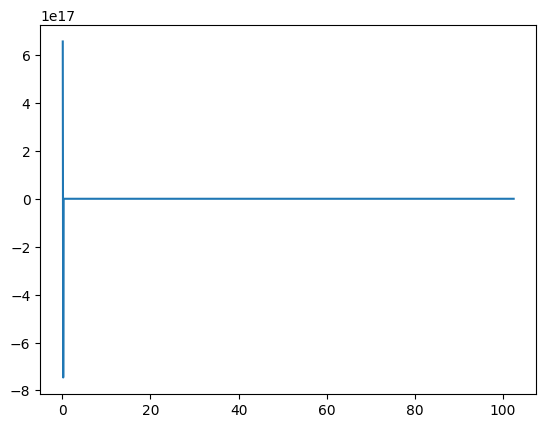

In [119]:
import matplotlib.pyplot as plt

plt.plot(time, y.real)
plt.show()

$\alpha$-circulant matrices are very similar to circulant matrices, except that the circulant entries are scaled by a small parameter $\alpha\in(0,1]$. For our all-at-once system this will look like:

$$
\begin{pmatrix}
 1 &  0 &  0 & -\alpha \\
-1 &  1 &  0 & 0 \\
 0 & -1 &  1 & 0 \\
 0 &  0 & -1 & 1 \\
\end{pmatrix}
\frac{1}{\Delta t}
-
\begin{pmatrix}
\theta     & 0          & 0          & \alpha(1-\theta) \\
(1-\theta) & \theta     & 0          & 0 \\
0          & (1-\theta) & \theta     & 0 \\
0          & 0          & (1-\theta) & \theta \\
\end{pmatrix}
\lambda
=
\textbf{C}^{(\alpha)}_{1}\frac{1}{\Delta t} - \textbf{C}^{(\alpha)}_{2}\lambda
$$

Clearly the standard circulant matrix is recovered when $\alpha=1$. Fortunately for us, just like the standard circulant matrices all $\alpha$-circulant matrices with the same $\alpha$ can be simultaneously diagonalised. The eigendecomposition is still known analytically but is slightly more complicated:

$$
\textbf{C}^{(\alpha)} = \textbf{V}\textbf{D}\textbf{V}^{-1}
$$
where:
$$
\textbf{V}^{-1} = \textbf{F}\Gamma_{\alpha},
\quad
\textbf{D} = \textbf{F}\Gamma_{\alpha}\textbf{C}[:,0]
$$
and $\Gamma_{\alpha}$ is the diagonal matrix:
$$
\Gamma_{\alpha} = \text{diag}\left(\alpha^{\frac{k-1}{N_{t}}}\right)\; \forall k \in [1, N_{t}]
$$

To use this matrix as a preconditioner we will again create a `LinearOperator`. Complete the class skeleton below by finishing the `__init__` method and implementing the `_matvec` method.

In [122]:
class AlphaCirculantLinearOperator(spla.LinearOperator):
    def __init__(self, col, alpha=1):
        """
        :arg col: the first column of the matrix
        :arg alpha: the circulant parameter
        """
        self.dtype = col.dtype
        n = len(col)
        self.shape = tuple((n, n))
        self.col = col
        self.lastcol = col[::-1]
        self.lastcol[0] = alpha
    def _print(self):
      print(self.lastcol)

    #def _matvec(self, v):
        # implement this method

Now we can try out our new preconditioner. We can pick some small value of $\alpha$ and see how the preconditioner performs.

In [ ]:
alpha = 0.1

Pa = AlphaCirculantLinearOperator(acol, alpha)

niterations=0

y, exit_code = spla.gmres(A, rhs, M=Pa,
                          callback=gmres_callback,
                          callback_type='pr_norm')

print(f"gmres exit code: {exit_code}")
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(y))}")

The solver again converges in two iterations, as expected for the case of a linear scalar ODE, but this time the residual at the first iteration is much smaller. Try different values of $\alpha$ and see how this affects the residuals. You might have to reduce the `tol` and `atol` to make sure two iterations are still carried out.
Some other questions you could look into are:
- What does a plot of the residual after one iteration vs $\alpha$ look like?
- What happens when $\alpha$ approaches machine zero?
- What happens if you change the problem parameters, e.g. `nt`, `dt`, `lamda`?
- What is the expected speedup for the iterations with various $\alpha$ or $N_{t}$?

_You should check your implementation of the $\alpha$-circulant operator by setting `alpha=1` and verifying that you get the same residuals as with the standard circulant operator above. This doesn't rule out all mistakes but is still good to do._